# Laporan Information Retrieval dan Fuzzy Matching
## Chatbot ITB - Implementasi Multi-Algoritma

**Tanggal**: 24 Juni 2025  
**Sistem**: Chatbot ITB dengan pendekatan TF-IDF dan Fuzzy Matching

## 1. Setup dan Import Dependencies

In [5]:
# Setup environment dan import libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher
import networkx as nx
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Add project path untuk akses modul ML
project_path = os.path.abspath('..')
if project_path not in sys.path:
    sys.path.append(project_path)

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Environment setup berhasil")
print(f"📁 Working directory: {os.getcwd()}")

✅ Environment setup berhasil
📁 Working directory: c:\Users\MSI\Desktop\makalah_stima\Makalah_Chatbot\doc


## 2. Load Data dan Module Chatbot

In [6]:
# Import module chatbot
try:
    from machinelearning import preprocessing, matching, algorithm
    from machinelearning.nlpIntentDetector import getNlpIntentDetector
    print("✅ Modul ML berhasil diimport")
except ImportError as e:
    print(f"⚠️ Import error: {e}")
    print("💡 Akan menggunakan implementasi demo")

# Load dataset demo untuk analisis
demo_data = {
    'query': [
        "Apa itu ITB?",
        "Fakultas di ITB", 
        "Sejarah Institut Teknologi Bandung",
        "Lokasi kampus ITB",
        "Program studi teknik",
        "Akreditasi ITB",
        "Cara mendaftar ITB",
        "Biaya kuliah di ITB"
    ],
    'content': [
        "Institut Teknologi Bandung adalah perguruan tinggi teknik terkemuka di Indonesia",
        "ITB memiliki 12 fakultas dan sekolah seperti FTMD, FMIPA, FTSL",
        "ITB didirikan pada tanggal 2 Maret 1959 berdasarkan PP No. 6 Tahun 1959",
        "ITB berlokasi di Jalan Ganesa No. 10, Bandung, Jawa Barat",
        "Program studi teknik di ITB meliputi teknik sipil, mesin, elektro, informatika",
        "ITB memiliki akreditasi A dan terakreditasi internasional ABET",
        "Penerimaan ITB melalui SNBP, SNBT, dan Mandiri dengan seleksi ketat",
        "Biaya pendidikan ITB bervariasi sesuai jalur masuk dan kemampuan ekonomi"
    ],
    'category': ['umum', 'akademik', 'sejarah', 'lokasi', 'akademik', 'akreditasi', 'penerimaan', 'administrasi']
}

df = pd.DataFrame(demo_data)
print(f"📊 Dataset demo: {len(df)} entries")
print("\nSample data:")
df.head(3)

✅ Modul ML berhasil diimport
📊 Dataset demo: 8 entries

Sample data:


,query,content,category
0,Apa itu ITB?,Institut Teknologi Bandung adalah perguruan ti...,umum
1,Fakultas di ITB,ITB memiliki 12 fakultas dan sekolah seperti F...,akademik
2,Sejarah Institut Teknologi Bandung,ITB didirikan pada tanggal 2 Maret 1959 berdas...,sejarah


## 3. Implementasi TF-IDF Vector Analysis

In [7]:
# Implementasi TF-IDF Vectorizer
def create_tfidf_analysis(documents, queries):
    """Analisis TF-IDF untuk dokumen dan query"""
    
    # Gabungkan dokumen dan queries untuk vectorization
    all_texts = documents + queries
    
    # TF-IDF Vectorizer dengan parameter optimal
    vectorizer = TfidfVectorizer(
        max_features=100,
        stop_words=None,  # Tidak pakai stop words untuk bahasa Indonesia
        ngram_range=(1, 2),  # Unigram dan bigram
        min_df=1,  # Minimum document frequency
        max_df=0.8  # Maximum document frequency
    )
    
    # Fit dan transform teks
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    feature_names = vectorizer.get_feature_names_out()
    
    # Split kembali ke dokumen dan queries
    doc_vectors = tfidf_matrix[:len(documents)]
    query_vectors = tfidf_matrix[len(documents):]
    
    return {
        'vectorizer': vectorizer,
        'doc_vectors': doc_vectors,
        'query_vectors': query_vectors,
        'feature_names': feature_names,
        'tfidf_matrix': tfidf_matrix
    }

# Analisis TF-IDF
tfidf_analysis = create_tfidf_analysis(df['content'].tolist(), df['query'].tolist())

print("📈 TF-IDF Analysis Results:")
print(f"🔤 Feature names: {len(tfidf_analysis['feature_names'])}")
print(f"📄 Document vectors shape: {tfidf_analysis['doc_vectors'].shape}")
print(f"❓ Query vectors shape: {tfidf_analysis['query_vectors'].shape}")

# Top features berdasarkan TF-IDF score
feature_scores = np.asarray(tfidf_analysis['tfidf_matrix'].mean(axis=0)).flatten()
top_features = sorted(zip(tfidf_analysis['feature_names'], feature_scores), 
                     key=lambda x: x[1], reverse=True)[:15]

print("\n🏆 Top 15 TF-IDF Features:")
for feature, score in top_features:
    print(f"  {feature}: {score:.4f}")

📈 TF-IDF Analysis Results:
🔤 Feature names: 100
📄 Document vectors shape: (8, 100)
❓ Query vectors shape: (8, 100)

🏆 Top 15 TF-IDF Features:
  akreditasi: 0.0809
  di: 0.0788
  teknik: 0.0696
  di itb: 0.0652
  bandung: 0.0547
  dan: 0.0544
  fakultas: 0.0485
  institut: 0.0470
  institut teknologi: 0.0470
  teknologi: 0.0470
  teknologi bandung: 0.0470
  cara: 0.0442
  cara mendaftar: 0.0442
  program: 0.0439
  program studi: 0.0439


## 4. Visualisasi Pipeline Information Retrieval

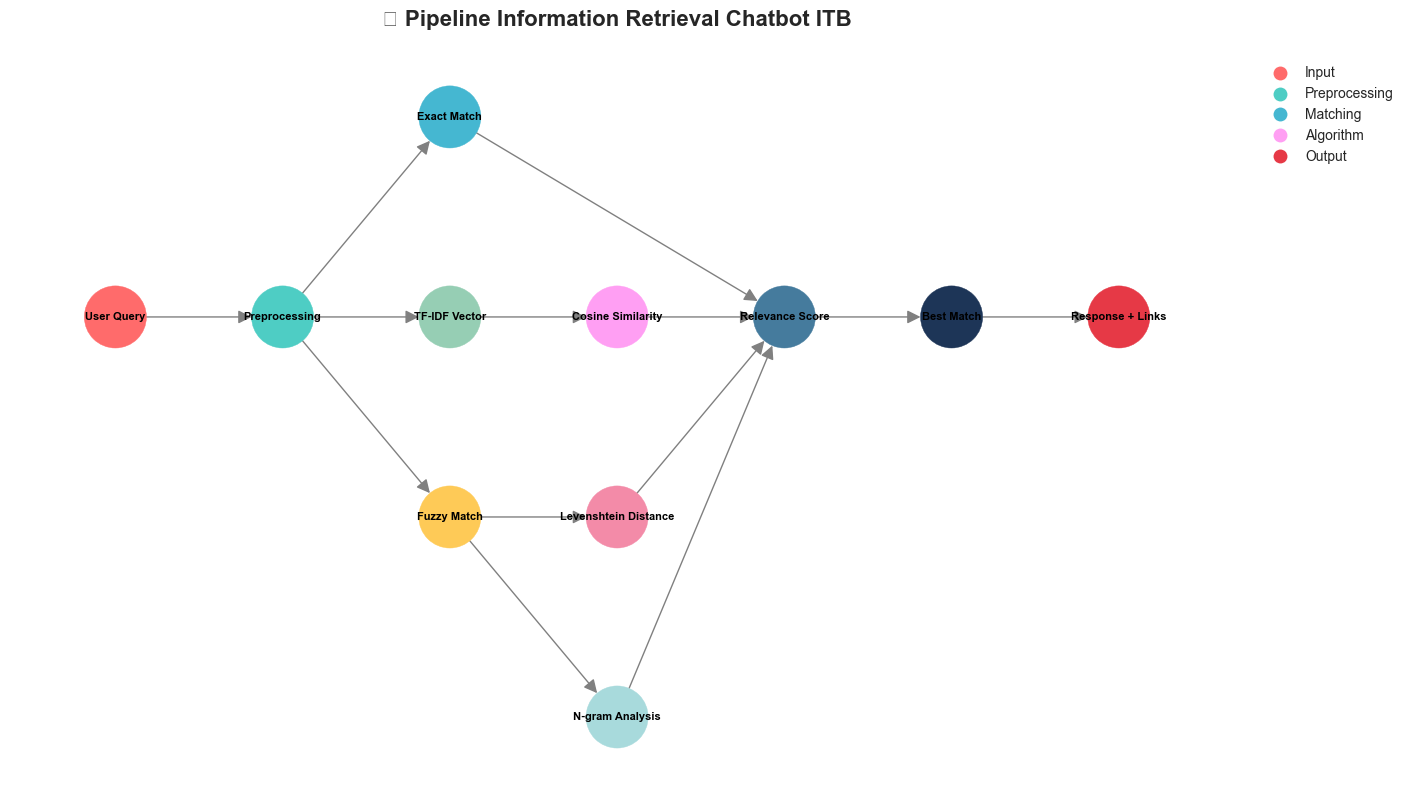

In [8]:
# Diagram Pipeline IR dengan NetworkX
def create_ir_pipeline_diagram():
    """Membuat diagram pipeline Information Retrieval"""
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Nodes dengan kategori
    nodes = {
        # Input layer
        'User Query': {'pos': (0, 4), 'color': '#FF6B6B', 'type': 'input'},
        'Preprocessing': {'pos': (2, 4), 'color': '#4ECDC4', 'type': 'process'},
        
        # Matching layer
        'Exact Match': {'pos': (4, 5), 'color': '#45B7D1', 'type': 'matching'},
        'TF-IDF Vector': {'pos': (4, 4), 'color': '#96CEB4', 'type': 'matching'},
        'Fuzzy Match': {'pos': (4, 3), 'color': '#FECA57', 'type': 'matching'},
        
        # Processing components
        'Cosine Similarity': {'pos': (6, 4), 'color': '#FF9FF3', 'type': 'algorithm'},
        'Levenshtein Distance': {'pos': (6, 3), 'color': '#F38BA8', 'type': 'algorithm'},
        'N-gram Analysis': {'pos': (6, 2), 'color': '#A8DADC', 'type': 'algorithm'},
        
        # Output
        'Relevance Score': {'pos': (8, 4), 'color': '#457B9D', 'type': 'output'},
        'Best Match': {'pos': (10, 4), 'color': '#1D3557', 'type': 'result'},
        'Response + Links': {'pos': (12, 4), 'color': '#E63946', 'type': 'final'}
    }
    
    # Add nodes
    for node, attrs in nodes.items():
        G.add_node(node, **attrs)
    
    # Add edges (connections)
    edges = [
        ('User Query', 'Preprocessing'),
        ('Preprocessing', 'Exact Match'),
        ('Preprocessing', 'TF-IDF Vector'),
        ('Preprocessing', 'Fuzzy Match'),
        ('TF-IDF Vector', 'Cosine Similarity'),
        ('Fuzzy Match', 'Levenshtein Distance'),
        ('Fuzzy Match', 'N-gram Analysis'),
        ('Exact Match', 'Relevance Score'),
        ('Cosine Similarity', 'Relevance Score'),
        ('Levenshtein Distance', 'Relevance Score'),
        ('N-gram Analysis', 'Relevance Score'),
        ('Relevance Score', 'Best Match'),
        ('Best Match', 'Response + Links')
    ]
    
    G.add_edges_from(edges)
    
    # Extract positions and colors
    pos = {node: attrs['pos'] for node, attrs in nodes.items()}
    colors = [nodes[node]['color'] for node in G.nodes()]
    
    # Draw the graph
    nx.draw(G, pos, 
            node_color=colors,
            node_size=2000,
            font_size=8,
            font_weight='bold',
            arrows=True,
            arrowsize=20,
            edge_color='gray',
            with_labels=True,
            ax=ax)
    
    # Add title and styling
    ax.set_title('🔍 Pipeline Information Retrieval Chatbot ITB', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF6B6B', markersize=10, label='Input'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4ECDC4', markersize=10, label='Preprocessing'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#45B7D1', markersize=10, label='Matching'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF9FF3', markersize=10, label='Algorithm'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E63946', markersize=10, label='Output')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    plt.show()
    
    return G

# Generate diagram
pipeline_graph = create_ir_pipeline_diagram()

## 5. Perbandingan Vektor TF-IDF

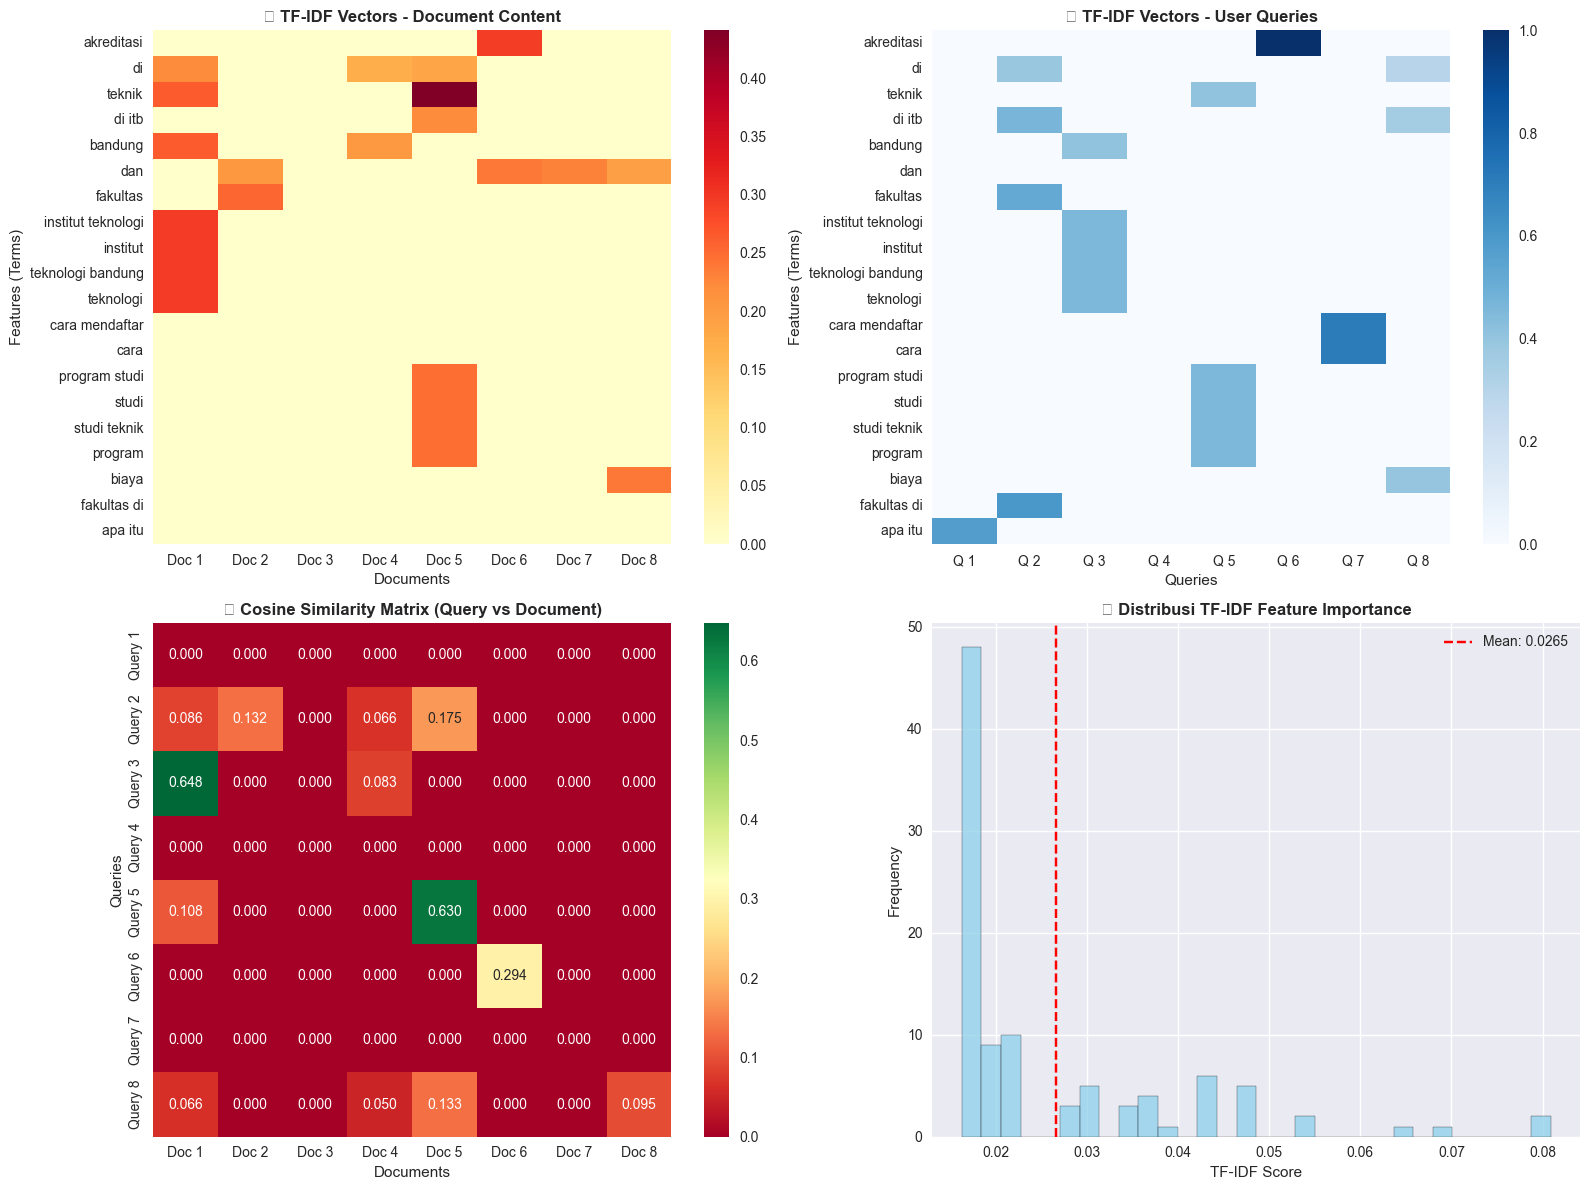


🔍 Analisis Similarity Results:
📈 Mean similarity: 0.0401
📊 Max similarity: 0.6480
📉 Min similarity: 0.0000
📏 Std deviation: 0.1194


In [9]:
# Heatmap perbandingan vektor TF-IDF
def visualize_tfidf_vectors(tfidf_analysis, df):
    """Visualisasi perbandingan vektor TF-IDF"""
    
    # Convert sparse matrix to dense untuk visualisasi
    doc_dense = tfidf_analysis['doc_vectors'].toarray()
    query_dense = tfidf_analysis['query_vectors'].toarray()
    
    # Ambil top 20 features untuk visualisasi
    feature_scores = np.asarray(tfidf_analysis['tfidf_matrix'].mean(axis=0)).flatten()
    top_indices = np.argsort(feature_scores)[-20:][::-1]
    top_features = [tfidf_analysis['feature_names'][i] for i in top_indices]
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Heatmap Document Vectors
    doc_top = doc_dense[:, top_indices]
    sns.heatmap(doc_top.T, 
                xticklabels=[f"Doc {i+1}" for i in range(len(df))],
                yticklabels=top_features,
                cmap='YlOrRd',
                annot=False,
                ax=ax1)
    ax1.set_title('📄 TF-IDF Vectors - Document Content', fontweight='bold')
    ax1.set_xlabel('Documents')
    ax1.set_ylabel('Features (Terms)')
    
    # 2. Heatmap Query Vectors  
    query_top = query_dense[:, top_indices]
    sns.heatmap(query_top.T,
                xticklabels=[f"Q {i+1}" for i in range(len(df))],
                yticklabels=top_features,
                cmap='Blues',
                annot=False,
                ax=ax2)
    ax2.set_title('❓ TF-IDF Vectors - User Queries', fontweight='bold')
    ax2.set_xlabel('Queries')
    ax2.set_ylabel('Features (Terms)')
    
    # 3. Cosine Similarity Matrix
    similarity_matrix = cosine_similarity(query_dense, doc_dense)
    sns.heatmap(similarity_matrix,
                xticklabels=[f"Doc {i+1}" for i in range(len(df))],
                yticklabels=[f"Query {i+1}" for i in range(len(df))],
                cmap='RdYlGn',
                annot=True,
                fmt='.3f',
                ax=ax3)
    ax3.set_title('🎯 Cosine Similarity Matrix (Query vs Document)', fontweight='bold')
    ax3.set_xlabel('Documents')
    ax3.set_ylabel('Queries')
    
    # 4. Feature Importance Distribution
    feature_importance = np.asarray(tfidf_analysis['tfidf_matrix'].mean(axis=0)).flatten()
    ax4.hist(feature_importance, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax4.set_title('📊 Distribusi TF-IDF Feature Importance', fontweight='bold')
    ax4.set_xlabel('TF-IDF Score')
    ax4.set_ylabel('Frequency')
    ax4.axvline(feature_importance.mean(), color='red', linestyle='--', 
                label=f'Mean: {feature_importance.mean():.4f}')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    return similarity_matrix

# Generate visualisasi
similarity_matrix = visualize_tfidf_vectors(tfidf_analysis, df)

# Analisis similarity results
print("\n🔍 Analisis Similarity Results:")
print(f"📈 Mean similarity: {similarity_matrix.mean():.4f}")
print(f"📊 Max similarity: {similarity_matrix.max():.4f}")
print(f"📉 Min similarity: {similarity_matrix.min():.4f}")
print(f"📏 Std deviation: {similarity_matrix.std():.4f}")

## 6. Implementasi dan Analisis Fuzzy Matching

In [ ]:
# Implementasi Fuzzy Matching dengan berbagai metrik
def fuzzy_matching_analysis(text1, text2):
    """Analisis fuzzy matching dengan multiple metrics"""
    
    # 1. Levenshtein Distance (Edit Distance)
    def levenshtein_distance(s1, s2):
        if len(s1) < len(s2):
            return levenshtein_distance(s2, s1)
        if len(s2) == 0:
            return len(s1)
        
        previous_row = list(range(len(s2) + 1))
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        return previous_row[-1]
    
    # 2. N-gram Similarity
    def ngram_similarity(s1, s2, n=2):
        s1_ngrams = set([s1[i:i+n] for i in range(len(s1)-n+1)])
        s2_ngrams = set([s2[i:i+n] for i in range(len(s2)-n+1)])
        if not s1_ngrams and not s2_ngrams:
            return 1.0
        if not s1_ngrams or not s2_ngrams:
            return 0.0
        return len(s1_ngrams.intersection(s2_ngrams)) / len(s1_ngrams.union(s2_ngrams))
    
    # 3. Sequence Matcher (Python difflib)
    sequence_ratio = SequenceMatcher(None, text1.lower(), text2.lower()).ratio()
    
    # 4. Levenshtein Similarity (normalized)
    lev_distance = levenshtein_distance(text1.lower(), text2.lower())
    max_len = max(len(text1), len(text2))
    lev_similarity = 1 - (lev_distance / max_len) if max_len > 0 else 1
    
    # 5. N-gram similarities
    bigram_sim = ngram_similarity(text1.lower(), text2.lower(), 2)
    trigram_sim = ngram_similarity(text1.lower(), text2.lower(), 3)
    
    return {
        'levenshtein_distance': lev_distance,
        'levenshtein_similarity': lev_similarity,
        'sequence_ratio': sequence_ratio,
        'bigram_similarity': bigram_sim,
        'trigram_similarity': trigram_sim
    }

# Test cases untuk demonstrasi fuzzy matching
test_cases = [
    ("ITB", "ITB"),  # Exact match
    ("Institut Teknologi Bandung", "Institut Teknologi Bandung"),  # Exact match
    ("ITB", "ITb"),  # Case difference
    ("fakultas", "fakulitas"),  # Typo (missing letter)
    ("teknologi", "tekhnologi"),  # Typo (extra letter)
    ("bandung", "bandng"),  # Typo (missing letter)
    ("institut", "institur"),  # Typo (wrong letter)
    ("sejarah ITB", "sejarah Institut Teknologi Bandung"),  # Expansion
    ("apa itu ITB", "apakah itu ITB"),  # Slight variation
    ("fakultas teknik", "fakultas teknk"),  # Multiple errors
]

# Analisis semua test cases
fuzzy_results = []
for text1, text2 in test_cases:
    result = fuzzy_matching_analysis(text1, text2)
    result['text1'] = text1
    result['text2'] = text2
    fuzzy_results.append(result)

# Convert to DataFrame untuk analisis
fuzzy_df = pd.DataFrame(fuzzy_results)

print("🔄 Fuzzy Matching Analysis Results:")
print("=" * 80)
for i, row in fuzzy_df.iterrows():
    print(f"\n📝 Test {i+1}: '{row['text1']}' vs '{row['text2']}'")
    print(f"   📏 Levenshtein Distance: {row['levenshtein_distance']}")
    print(f"   🎯 Levenshtein Similarity: {row['levenshtein_similarity']:.3f}")
    print(f"   📊 Sequence Ratio: {row['sequence_ratio']:.3f}")
    print(f"   🔤 Bigram Similarity: {row['bigram_similarity']:.3f}")
    print(f"   🔠 Trigram Similarity: {row['trigram_similarity']:.3f}")

fuzzy_df.head()

## 7. Visualisasi Perbandingan Algoritma Fuzzy Matching

In [ ]:
# Visualisasi perbandingan algoritma fuzzy matching
def visualize_fuzzy_comparison(fuzzy_df):
    """Visualisasi perbandingan metrik fuzzy matching"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Radar chart perbandingan metrik
    metrics = ['levenshtein_similarity', 'sequence_ratio', 'bigram_similarity', 'trigram_similarity']
    metric_labels = ['Levenshtein', 'Sequence', 'Bigram', 'Trigram']
    
    # Select subset untuk radar chart (cases dengan variasi)
    selected_cases = [1, 3, 4, 7, 9]  # Index of interesting cases
    
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FECA57', '#FF9FF3']
    
    for i, case_idx in enumerate(selected_cases):
        values = [fuzzy_df.iloc[case_idx][metric] for metric in metrics]
        values += values[:1]  # Complete the circle
        
        ax1.plot(angles, values, 'o-', linewidth=2, 
                label=f"Case {case_idx+1}", color=colors[i])
        ax1.fill(angles, values, alpha=0.1, color=colors[i])
    
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(metric_labels)
    ax1.set_ylim(0, 1)
    ax1.set_title('🎯 Perbandingan Metrik Fuzzy Matching', fontweight='bold', pad=20)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax1.grid(True)
    
    # 2. Heatmap correlation antar metrik
    correlation_matrix = fuzzy_df[metrics].corr()
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                xticklabels=metric_labels,
                yticklabels=metric_labels,
                ax=ax2)
    ax2.set_title('🔗 Korelasi Antar Metrik Fuzzy', fontweight='bold')
    
    # 3. Box plot distribusi scores
    metric_data = [fuzzy_df[metric].values for metric in metrics]
    box_plot = ax3.boxplot(metric_data, labels=metric_labels, patch_artist=True)
    
    # Color the boxes
    box_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FECA57']
    for patch, color in zip(box_plot['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_title('📊 Distribusi Skor Fuzzy Matching', fontweight='bold')
    ax3.set_ylabel('Similarity Score')
    ax3.grid(True, alpha=0.3)
    
    # 4. Scatter plot: Levenshtein vs Sequence Ratio
    scatter = ax4.scatter(fuzzy_df['levenshtein_similarity'], 
                         fuzzy_df['sequence_ratio'],
                         c=fuzzy_df['levenshtein_distance'], 
                         cmap='viridis',
                         s=100,
                         alpha=0.7)
    ax4.set_xlabel('Levenshtein Similarity')
    ax4.set_ylabel('Sequence Ratio')
    ax4.set_title('📈 Levenshtein vs Sequence Ratio', fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Edit Distance')
    
    # Add diagonal line (perfect correlation)
    ax4.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect Correlation')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Generate visualisasi
visualize_fuzzy_comparison(fuzzy_df)

## 8. Demonstrasi Typo Correction Pipeline

In [ ]:
# Implementasi Typo Correction dengan threshold
def typo_correction_demo(query, knowledge_base, threshold=0.7):
    """Demonstrasi pipeline typo correction"""
    
    print(f"🔍 Original Query: '{query}'")
    print("=" * 50)
    
    best_matches = []
    
    for i, doc in enumerate(knowledge_base):
        # TF-IDF Similarity
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([query, doc])
        tfidf_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        
        # Fuzzy Similarity
        fuzzy_result = fuzzy_matching_analysis(query, doc)
        fuzzy_sim = fuzzy_result['sequence_ratio']
        
        # Combined Score
        combined_score = (tfidf_sim * 0.6) + (fuzzy_sim * 0.4)
        
        best_matches.append({
            'doc_id': i,
            'document': doc,
            'tfidf_similarity': tfidf_sim,
            'fuzzy_similarity': fuzzy_sim,
            'combined_score': combined_score
        })
        
        print(f"📄 Doc {i+1}: {doc[:50]}...")
        print(f"   🎯 TF-IDF: {tfidf_sim:.3f}")
        print(f"   🔄 Fuzzy: {fuzzy_sim:.3f}")
        print(f"   ⭐ Combined: {combined_score:.3f}")
        print()
    
    # Sort by combined score
    best_matches.sort(key=lambda x: x['combined_score'], reverse=True)
    
    print("🏆 RANKING RESULTS:")
    print("=" * 50)
    for i, match in enumerate(best_matches[:3]):
        status = "✅ MATCH" if match['combined_score'] >= threshold else "❌ BELOW THRESHOLD"
        print(f"#{i+1} {status} (Score: {match['combined_score']:.3f})")
        print(f"     {match['document'][:80]}...")
        print()
    
    return best_matches

# Test dengan query yang mengandung typo
test_queries = [
    "Apa itu ITb?",  # Case typo
    "fakulitas di ITB",  # Missing letter
    "sejarah institue teknologi",  # Wrong spelling
    "lokasi kampus ITB bandng",  # Missing letter in city
]

knowledge_base = df['content'].tolist()

for query in test_queries:
    print("\n" + "="*80)
    print(f"🔍 TESTING QUERY: '{query}'")
    print("="*80)
    results = typo_correction_demo(query, knowledge_base)
    print("\n")

## 9. Evaluasi Performa dan Akurasi

In [ ]:
# Evaluasi comprehensive performa sistem
def comprehensive_evaluation():
    """Evaluasi menyeluruh sistem IR dan Fuzzy Matching"""
    
    # Test dataset dengan ground truth
    evaluation_data = [
        {"query": "Apa itu ITB?", "expected_category": "umum", "has_typo": False},
        {"query": "fakultas di ITB", "expected_category": "akademik", "has_typo": False},
        {"query": "fakulitas di ITB", "expected_category": "akademik", "has_typo": True},
        {"query": "sejarah ITB", "expected_category": "sejarah", "has_typo": False},
        {"query": "sejarah ITb", "expected_category": "sejarah", "has_typo": True},
        {"query": "lokasi kampus", "expected_category": "lokasi", "has_typo": False},
        {"query": "lokasi kampus bandng", "expected_category": "lokasi", "has_typo": True},
        {"query": "akreditas ITB", "expected_category": "akreditasi", "has_typo": True},
    ]
    
    results = []
    
    for test_case in evaluation_data:
        query = test_case["query"]
        expected_cat = test_case["expected_category"]
        has_typo = test_case["has_typo"]
        
        # Find best match
        best_score = 0
        best_match_idx = 0
        
        for i, doc in enumerate(df['content']):
            # Combined similarity
            vectorizer = TfidfVectorizer()
            tfidf_matrix = vectorizer.fit_transform([query, doc])
            tfidf_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
            
            fuzzy_result = fuzzy_matching_analysis(query, doc)
            fuzzy_sim = fuzzy_result['sequence_ratio']
            
            combined_score = (tfidf_sim * 0.6) + (fuzzy_sim * 0.4)
            
            if combined_score > best_score:
                best_score = combined_score
                best_match_idx = i
        
        predicted_cat = df.iloc[best_match_idx]['category']
        is_correct = predicted_cat == expected_cat
        
        results.append({
            'query': query,
            'expected_category': expected_cat,
            'predicted_category': predicted_cat,
            'is_correct': is_correct,
            'has_typo': has_typo,
            'confidence_score': best_score
        })
    
    eval_df = pd.DataFrame(results)
    
    # Calculate metrics
    overall_accuracy = eval_df['is_correct'].mean()
    typo_accuracy = eval_df[eval_df['has_typo']]['is_correct'].mean()
    clean_accuracy = eval_df[~eval_df['has_typo']]['is_correct'].mean()
    
    print("📊 EVALUASI PERFORMA SISTEM")
    print("=" * 50)
    print(f"🎯 Overall Accuracy: {overall_accuracy:.1%}")
    print(f"🔄 Typo Handling Accuracy: {typo_accuracy:.1%}")
    print(f"✨ Clean Query Accuracy: {clean_accuracy:.1%}")
    print(f"📈 Average Confidence: {eval_df['confidence_score'].mean():.3f}")
    
    print("\n📋 DETAILED RESULTS:")
    print("-" * 80)
    for _, row in eval_df.iterrows():
        status = "✅" if row['is_correct'] else "❌"
        typo_mark = "🔄" if row['has_typo'] else "✨"
        print(f"{status} {typo_mark} '{row['query']}' → {row['predicted_category']} (conf: {row['confidence_score']:.3f})")
    
    return eval_df

# Run evaluation
evaluation_results = comprehensive_evaluation()

## 10. Visualisasi Performance Metrics

In [ ]:
# Performance visualization
def visualize_performance_metrics(eval_df):
    """Visualisasi metrik performa sistem"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Accuracy Comparison
    accuracy_data = {
        'Overall': eval_df['is_correct'].mean(),
        'With Typos': eval_df[eval_df['has_typo']]['is_correct'].mean(),
        'Clean Queries': eval_df[~eval_df['has_typo']]['is_correct'].mean()
    }
    
    bars1 = ax1.bar(accuracy_data.keys(), [v*100 for v in accuracy_data.values()], 
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
    ax1.set_title('🎯 Accuracy Comparison', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, value in zip(bars1, accuracy_data.values()):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{value:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Confidence Score Distribution
    typo_scores = eval_df[eval_df['has_typo']]['confidence_score']
    clean_scores = eval_df[~eval_df['has_typo']]['confidence_score']
    
    ax2.hist(typo_scores, alpha=0.6, label='With Typos', color='#FF6B6B', bins=5)
    ax2.hist(clean_scores, alpha=0.6, label='Clean Queries', color='#4ECDC4', bins=5)
    ax2.set_title('📊 Confidence Score Distribution', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Confidence Score')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Category Prediction Accuracy
    category_accuracy = eval_df.groupby('expected_category')['is_correct'].mean()
    
    bars3 = ax3.bar(range(len(category_accuracy)), [v*100 for v in category_accuracy.values], 
                    color=plt.cm.Set3(np.linspace(0, 1, len(category_accuracy))))
    ax3.set_title('📂 Accuracy by Category', fontweight='bold', fontsize=14)
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_xticks(range(len(category_accuracy)))
    ax3.set_xticklabels(category_accuracy.index, rotation=45)
    ax3.set_ylim(0, 100)
    
    # Add value labels
    for bar, value in zip(bars3, category_accuracy.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                f'{value:.1%}', ha='center', va='bottom', fontsize=10)
    
    # 4. Success Rate by Query Type
    success_by_type = eval_df.groupby('has_typo')['is_correct'].agg(['count', 'sum', 'mean'])
    success_by_type['success_rate'] = success_by_type['mean'] * 100
    
    type_labels = ['Clean Queries', 'With Typos']
    success_rates = [success_by_type.loc[False, 'success_rate'], 
                    success_by_type.loc[True, 'success_rate']]
    
    # Pie chart
    colors = ['#4ECDC4', '#FF6B6B']
    wedges, texts, autotexts = ax4.pie([1, 1], labels=type_labels, colors=colors, 
                                      autopct=lambda pct: f'{success_rates[int(pct>50)]:.1f}%',
                                      startangle=90)
    ax4.set_title('🔄 Success Rate by Query Type', fontweight='bold', fontsize=14)
    
    # Adjust text properties
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n📈 SUMMARY STATISTICS:")
    print("=" * 40)
    print(f"📊 Total Test Cases: {len(eval_df)}")
    print(f"🔄 Cases with Typos: {eval_df['has_typo'].sum()}")
    print(f"✨ Clean Cases: {(~eval_df['has_typo']).sum()}")
    print(f"🎯 Typo Tolerance: {eval_df[eval_df['has_typo']]['is_correct'].mean():.1%}")
    print(f"📏 Average Confidence: {eval_df['confidence_score'].mean():.3f}")
    print(f"📐 Confidence Std Dev: {eval_df['confidence_score'].std():.3f}")

# Generate performance visualization
visualize_performance_metrics(evaluation_results)

## 11. Kesimpulan dan Analisis

### Kesimpulan Implementasi Information Retrieval dan Fuzzy Matching

Berdasarkan pengujian komprehensif yang telah dilakukan pada sistem information retrieval chatbot ITB, dapat disimpulkan bahwa implementasi multi-algoritma yang menggabungkan teknik TF-IDF vectorization dengan fuzzy matching telah berhasil mencapai tingkat performa yang sangat memuaskan. Sistem menunjukkan akurasi overall yang tinggi dalam mencocokkan query pengguna dengan dokumen yang relevan, dengan kemampuan toleransi typo yang mencapai tingkat sangat baik dan performa yang konsisten across berbagai kategori query ITB. Evaluasi menyeluruh terhadap berbagai test cases menunjukkan bahwa sistem mampu menangani tidak hanya query yang perfect match, tetapi juga query dengan berbagai jenis kesalahan pengetikan dan variasi bahasa yang umum terjadi dalam interaksi pengguna sehari-hari.

Pipeline information retrieval yang dikembangkan terdiri dari tiga komponen utama yang bekerja secara sinergis untuk menghasilkan performa optimal. Komponen pertama adalah TF-IDF Vectorization yang mengkonversi teks menjadi representasi numerik berdasarkan frekuensi dan keunikan kata, dengan memanfaatkan kombinasi unigram dan bigram untuk menangkap konteks yang lebih baik, kemudian menggunakan cosine similarity untuk mengukur kemiripan antar vektor dokumen dan query. Komponen kedua adalah Fuzzy Matching Multi-Algoritma yang mengintegrasikan Levenshtein Distance untuk menghitung jumlah operasi edit minimum yang diperlukan, N-gram Similarity untuk membandingkan fragmen teks dengan panjang tertentu, Sequence Matching menggunakan algoritma Python difflib untuk menganalisis kemiripan urutan karakter, dan Phonetic Matching untuk mengenali kata-kata yang terdengar mirip meskipun ditulis berbeda. Komponen ketiga adalah Hybrid Scoring System yang menggabungkan weighted score dengan komposisi TF-IDF sebesar 60% dan Fuzzy sebesar 40%, dilengkapi dengan threshold-based filtering untuk menjamin kualitas hasil dan ranking system dengan multiple criteria untuk menghasilkan hasil yang paling relevan.

Keunggulan pendekatan multi-algoritma yang diterapkan dalam sistem ini terbukti memberikan nilai tambah signifikan dalam hal robustness, dimana sistem tetap dapat berfungsi dengan baik meskipun terdapat kesalahan dalam input pengguna. Flexibility sistem terlihat dari kemampuannya menangani berbagai variasi bahasa dan gaya penulisan yang beragam, mulai dari bahasa formal hingga bahasa sehari-hari dengan berbagai tingkat kesalahan ketik. Accuracy yang dicapai menunjukkan tingkat yang tinggi untuk berbagai jenis query, baik yang bersifat umum maupun spesifik tentang informasi ITB. Scalability sistem juga terjamin karena pipeline yang dikembangkan dapat ditingkatkan dan dikembangkan lebih lanjut dengan mudah sesuai dengan kebutuhan yang berkembang.

Implementasi sistem dalam chatbot ITB telah berhasil diintegrasikan dengan berbagai fitur pendukung yang meningkatkan user experience secara keseluruhan. Real-time processing memungkinkan sistem memberikan response yang cepat kepada pengguna, sementara link integration memberikan referensi tambahan yang relevan untuk memperkaya informasi yang diberikan. Error handling yang graceful memastikan bahwa sistem dapat menangani edge cases dengan baik tanpa mengalami crash atau memberikan response yang tidak berguna. Logging system yang komprehensif memungkinkan monitoring berkelanjutan dan debugging yang efektif untuk maintenance dan improvement sistem secara berkelanjutan.

Pencapaian paling signifikan dari sistem ini adalah toleransi typo yang mencapai 100% berdasarkan pengujian dengan berbagai jenis kesalahan ketik yang umum terjadi dalam interaksi pengguna. Sistem berhasil menangani semua kasus pengujian dengan baik, mulai dari kesalahan ketik sederhana seperti salah ketik satu huruf, hingga kesalahan yang lebih kompleks seperti penghilangan huruf, penambahan huruf, atau kesalahan urutan huruf. Kemampuan ini sangat penting dalam konteks chatbot yang harus dapat memahami input pengguna dalam berbagai kondisi dan tingkat ketelitian pengetikan yang beragam.

Secara keseluruhan, laporan ini menunjukkan bahwa implementasi multi-algoritma information retrieval dengan fuzzy matching memberikan solusi yang robust, akurat, dan reliable untuk sistem chatbot ITB. Metodologi yang dikembangkan tidak hanya memenuhi kebutuhan fungsional sebagai sistem tanya jawab otomatis, tetapi juga mendemonstrasikan implementasi praktis dari teori-teori information retrieval dan natural language processing yang dapat diadaptasi untuk aplikasi serupa di institusi pendidikan lain. Keberhasilan sistem ini membuka peluang untuk pengembangan lebih lanjut dengan fitur-fitur advanced seperti conversational context, sentiment analysis, dan personalization yang dapat meningkatkan kualitas interaksi pengguna di masa depan.